In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
!pip install tiktoken
import json
import re

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 6.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires openai, which is not installed.


In [ ]:
!unzip -o "secret_data.zip"

# Computing acc@k for each human answer against the other human answers (Table 2)

In [ ]:
def compute_accuracy_at_k(df, k):
    # Compute accuracy@k for each row by comparing with k most common values of other rows
    accuracy_scores = []
    for i in range(len(df)):
        top_k_values = df.drop(i).apply(lambda column: column.value_counts().index[:k]) #sorted by default
        values = top_k_values.values
        if k == 1:
            values = values.T
        top_k_values = [v.tolist() for v in values]
        row_values = df.iloc[i].tolist()  # Convert row_values to a regular list

        score = sum(row_value in top_k_value for row_value, top_k_value in zip(row_values, top_k_values)) / len(row_values)
        accuracy_scores.append(score)
    return accuracy_scores

def lowercase(cell):
    return cell.lower()

def capitalise(cell):
    return cell.capitalize()


data_dict = {'German': "deu", 'English': "eng", "Tamil": "tam", "Turkish":"tur"}
results_dict = {}
accuracy_dict = {}
wug_list = {}
k_values = [1, 3, 5]
for lang, lang_short in data_dict.items():
    if lang == "Turkish": continue
    df = pd.read_csv(f"human_annotations/{lang_short}_gold_data.csv", header=0, keep_default_na=False)
    wug_list[lang] = list(df.columns)
    if lang == 'English':  # convert to lowercase only for English
        df = df.applymap(lowercase)
    elif lang == 'German':
        df = df.applymap(capitalise)
    results_dict[lang] = df
    # Compute accuracy and standard deviation
    accuracy_dict[lang] = {}
    for k in k_values:
    # Compute accuracy@k for each row
        accuracy_scores = compute_accuracy_at_k(df, k)
        mean_accuracy = np.mean(accuracy_scores)
        std_dev = np.std(accuracy_scores)

        # Compute mean accuracy@k and standard deviation
        accuracy_dict[lang][f'accuracy@{k}'] = (
            round(mean_accuracy * 100, 2),
            round(std_dev * 100, 2)
        )

    print(lang)
    print(accuracy_dict[lang])

German
{'accuracy@1': (64.23, 10.26), 'accuracy@3': (86.34, 5.36), 'accuracy@5': (90.48, 4.66)}
English
{'accuracy@1': (67.14, 17.76), 'accuracy@3': (85.29, 13.06), 'accuracy@5': (87.64, 12.13)}
Tamil
{'accuracy@1': (37.09, 26.39), 'accuracy@3': (43.85, 26.95), 'accuracy@5': (43.85, 26.95)}


# Average unique form count for each language

In [ ]:
gold_freq_dict = {}

for lang, df in results_dict.items():
    freq_list = []
    for column in df.columns:
        df[column] = df[column].str.replace('\n', '').str.strip()  # removing newlines and stripping spaces
        column_freq = df[column].value_counts().to_dict()  # counting frequency
        freq_list.append(column_freq)
    gold_freq_dict[lang] = freq_list


In [ ]:
gold_freq_dict["German"][8]

{'Sater': 7,
 'Saters': 4,
 'Satere': 4,
 'Satres': 1,
 'Saten': 1,
 'Säter': 1,
 'Satare': 1,
 'Sateren': 1,
 'Satern': 1}

In [ ]:
turkish_df = pd.read_csv(f"human_annotations/tur_gold_data.csv", header=0, keep_default_na=False)
gold_dict_turkish = [{form:1 }for form in turkish_df.values[0]]
gold_freq_dict["Turkish"] = gold_dict_turkish
wug_list["Turkish"] = list(turkish_df.columns)

In [ ]:
import pandas as pd
import numpy as np

for lang, freq_dict in gold_freq_dict.items():
    average_unique_form_count = np.mean([len(form_dict) for form_dict in freq_dict])


    print(f'Language: {lang}, Average unique form count: {average_unique_form_count}')


Language: German, Average unique form count: 4.241379310344827
Language: English, Average unique form count: 5.66
Language: Tamil, Average unique form count: 3.0327868852459017
Language: Turkish, Average unique form count: 1.0


# Reading in results

In [ ]:
all_langs = ["German", "English", "Tamil", "Turkish"]
baseline_results_ARL = {}
for lang, lang_short in data_dict.items():
    baseline_results_ARL[lang] = pd.read_csv(f"baselines/arl/{lang_short}_arl.csv", header=0, keep_default_na=False)

baseline_results_mingen = {}
for lang, lang_short in data_dict.items():
    baseline_results_mingen[lang] = pd.read_csv(f"baselines/mingen/{lang_short}_mingen.csv", header=0, keep_default_na=False)

baseline_results_ppi_1 = {}
for lang, lang_short in data_dict.items():
    baseline_results_ppi_1[lang] = pd.read_csv(f"baselines/ppi/{lang_short}_ppi_1.csv", header=0, keep_default_na=False)

baseline_results_fit = {}
for lang, lang_short in data_dict.items():
    baseline_results_fit[lang] = pd.read_csv(f"baselines/fit/{lang_short}_fit.csv", header=0, keep_default_na=False)

baseline_results_aed = {}
for lang, lang_short in data_dict.items():
    baseline_results_aed[lang] = pd.read_csv(f"baselines/aed/{lang_short}_aed.csv", header=0, keep_default_na=False)

In [ ]:
shots = ["0", "1", "n"]
short_prompt_results = {}
for shot in shots:
    short_prompt_results[shot] = {}
    for lang, lang_short in data_dict.items():
        short_prompt_results[shot][lang] = pd.read_csv(f"chatgpt_prompt_results/short/{lang_short}_chatgpt-{shot}.csv", header=0, keep_default_na=False)

long_prompt_results = {}
for shot in shots:
    long_prompt_results[shot] = {}
    for lang, lang_short in data_dict.items():
        long_prompt_results[shot][lang] = pd.read_csv(f"chatgpt_prompt_results/long/{lang_short}_chatgpt-{shot}.csv", header=0, keep_default_na=False)

In [ ]:
one_shot_lists = {}
one_shot_lists["German"] = ["Fisch-Fische", "Tür-Türen", "Kind-Kinder", "Park-Parks", "Fenster-Fenster", "Tochter-Töchter", "Floß-Flöße", "Wald-Wälder"]
one_shot_lists["English"] = ["test-tested", "teach-taught", "build-built", "sing-sang", "hit-hit"]

In [ ]:
# This is a special case for MinGen, because the IPA conversion script will not work on google colab, we converted all possible forms offline and loaded them into a dict here. For AED, all gold answers had to be converted into a FAP.

ipa_dict = json.load(open('baselines/mingen/ipa_dict.json'))
aed_original = json.load(open('baselines/aed/original_string.json'))
aed_faps = json.load(open('baselines/aed/fap_string.json'))

original_to_fap = {}
for lang, things in aed_faps.items():
    for nonce_form, fap_list in things.items():
        original_list = aed_original[lang][nonce_form]
        for original, fap in zip(original_list, fap_list):
            original_to_fap[original] = fap

# Accuracy @ k functions

In [ ]:
import numpy as np

def calculate_accuracy_at_k(results_dict, gold_freq_dict, k=1, turkish_short=False):
    accuracies = {}
    accuracy_stats = {}

    for lang, results in results_dict.items():
        if lang not in gold_freq_dict: continue
        gold_freq_for_lang = gold_freq_dict[lang]

        lang_accuracies = []
        for row_i, result_items in results.iterrows():
            correct_items = 0
            for i, (result, column_freq_dict) in enumerate(zip(result_items, gold_freq_for_lang)):

                if turkish_short:
                    if lang == "Turkish" and i < 30:
                        continue
                else:
                    if lang == "Turkish" and i >= 30:
                        continue
                top_k_gold_answers = list((sorted(column_freq_dict.keys(), key=lambda x:column_freq_dict[x], reverse=True)))[:k]  # get top k answers from gold_freq_dict

                if result in top_k_gold_answers:
                    correct_items += 1

            if lang == "Turkish":
                if turkish_short: total_num = 10
                else: total_num = 30
            else:
                total_num = len(result_items)
            accuracy = correct_items / total_num
            lang_accuracies.append(accuracy)

        # Compute mean and standard deviation of accuracies
        mean_accuracy = np.mean(lang_accuracies)
        std_dev_accuracy = np.std(lang_accuracies)

        accuracies[lang] = lang_accuracies
        accuracy_stats[lang] = {'mean': mean_accuracy, 'std_dev': std_dev_accuracy}

    return accuracies, accuracy_stats

def calculate_accuracy_at_k_ipa(results_dict, gold_freq_dict, k=1, turkish_short=False):
    accuracies = {}
    accuracy_stats = {}

    for lang, results in results_dict.items():
        if lang not in gold_freq_dict: continue
        gold_freq_for_lang = gold_freq_dict[lang]

        # if results is a single string, convert it into a list
        lang_accuracies = []
        for row_i, result_items in results.iterrows():
            correct_items = 0
            for i, (result, column_freq_dict) in enumerate(zip(result_items, gold_freq_for_lang)):
                if turkish_short:
                    if lang == "Turkish" and i < 30:
                        continue
                else:
                    if lang == "Turkish" and i >= 30:
                        continue
                top_k_gold_answers = list((sorted(column_freq_dict.keys(), key=lambda x:column_freq_dict[x], reverse=True)))[:k]
                top_k_ipas = [ipa_dict[lang][gold] for gold in top_k_gold_answers]  # get top k answers from gold_freq_dict

                # print(result, top_k_ipas, result in top)
                # print(result)
                if result in top_k_ipas:
                    correct_items += 1

            if lang == "Turkish":
                if turkish_short: total_num = 10
                else: total_num = 30
            else:
                total_num = len(result_items)
            accuracy = correct_items / total_num
            lang_accuracies.append(accuracy)

        # Compute mean and standard deviation of accuracies
        mean_accuracy = np.mean(lang_accuracies)
        std_dev_accuracy = np.std(lang_accuracies)

        accuracies[lang] = lang_accuracies
        accuracy_stats[lang] = {'mean': mean_accuracy, 'std_dev': std_dev_accuracy}

    return accuracies, accuracy_stats

def calculate_accuracy_at_k_aed(results_dict, gold_freq_dict, k=1, turkish_short=False):
    accuracies = {}
    accuracy_stats = {}

    for lang, results in results_dict.items():
        if lang not in gold_freq_dict: continue
        gold_freq_for_lang = gold_freq_dict[lang]

        # if results is a single string, convert it into a list
        lang_accuracies = []
        for row_i, result_items in results.iterrows():
            correct_items = 0

            for i, (result, column_freq_dict) in enumerate(zip(result_items, gold_freq_for_lang)):
                if turkish_short:
                    if lang == "Turkish" and i < 30:
                        continue
                else:
                    if lang == "Turkish" and i >= 30:
                        continue
                top_k_gold_answers = list((sorted(column_freq_dict.keys(), key=lambda x:column_freq_dict[x], reverse=True)))[:k] # get top k answers from gold_freq_dict
                top_k_faps = [original_to_fap[form] for form in top_k_gold_answers]
                if result in top_k_faps:
                    correct_items += 1

            if lang == "Turkish":
                if turkish_short: total_num = 10
                else: total_num = 30
            else:
                total_num = len(result_items)
            accuracy = correct_items / total_num
            lang_accuracies.append(accuracy)

        # Compute mean and standard deviation of accuracies
        mean_accuracy = np.mean(lang_accuracies)
        std_dev_accuracy = np.std(lang_accuracies)

        accuracies[lang] = lang_accuracies
        accuracy_stats[lang] = {'mean': mean_accuracy, 'std_dev': std_dev_accuracy}

    return accuracies, accuracy_stats


# Generating Tables 5 and 8

In [ ]:
k_values = [1, 3, 5]
methods_results = {"ARL": baseline_results_ARL,
                   "MinGen": baseline_results_mingen,
                   "FIT": baseline_results_fit,
                   "PPI 1": baseline_results_ppi_1,
                   "AED": baseline_results_aed,
                   "long 0-shot": long_prompt_results["0"],
                   "long 1-shot": long_prompt_results["1"],
                   "long few-shot": long_prompt_results["n"],
                   "short 0-shot":short_prompt_results["0"],
                   "short 1-shot":short_prompt_results["1"],
                   "short few-shot":short_prompt_results["n"]}
final_results = {}

for method, results in methods_results.items():
    for k in k_values:
        if method == "MinGen":

            accuracies, accuracy_stats = calculate_accuracy_at_k_ipa(results, gold_freq_dict, k, True)
        elif method == "AED":
            accuracies, accuracy_stats = calculate_accuracy_at_k_aed(results, gold_freq_dict, k, True)
        else:
            accuracies, accuracy_stats = calculate_accuracy_at_k(results, gold_freq_dict, k, True)

        if method not in final_results:
            final_results[method] = {}
        final_results[method][k] = accuracy_stats

df_list = []
for method, method_results in final_results.items():
    for k, k_results in method_results.items():
        for language, lang_results in k_results.items():
            df_list.append([method, k, language, lang_results['mean'], lang_results['std_dev']])
df = pd.DataFrame(df_list, columns=['Method', 'K', 'Language', 'Mean', 'StdDev'])

# Combine 'Mean' and 'StdDev' into 'Mean ± StdDev' format, suppress '±' for 0 std dev
df['Mean ± StdDev'] = df.apply(lambda row: f"{row['Mean']*100:.2f} ± {row['StdDev']*100:.2f}" if row['Mean'] != '' and row['StdDev'] != 0 else f"{row['Mean']*100:.2f}", axis=1)

# Drop the original 'Mean' and 'StdDev' columns
df.drop(columns=['Mean', 'StdDev'], inplace=True)


# Filter the DataFrame to get data for the first table
df_table1 = df[((df['K'] == 5) & (df['Language'] != 'Turkish')) | ((df['K'] == 1) & (df['Language'] == 'Turkish'))]

# Create a pivot table with hierarchical column levels for the first table
pivot_table1 = df_table1.pivot_table(index='Method',
                                     columns='Language',
                                     values='Mean ± StdDev',
                                     aggfunc='first')

# Replace NaNs with empty strings
pivot_table1 = pivot_table1.replace(np.nan, '')
pivot_table1 = pivot_table1.sort_index(axis=1)

# Convert the first pivot table to latex
latex_table1 = pivot_table1.to_latex(index=True, multirow=True)
latex_table1 = latex_table1.replace('{l}', '{c}')

# Filter the DataFrame to get data for the second table
df_table2 = df[((df['K'] == 1) & (df['Language'] != 'Turkish')) | ((df['K'] == 3) & (df['Language'] != 'Turkish'))]

# Create a pivot table with hierarchical column levels for the second table
pivot_table2 = df_table2.pivot_table(index='Method',
                                     columns=['Language', 'K'],
                                     values='Mean ± StdDev',
                                     aggfunc='first')

# Replace NaNs with empty strings
pivot_table2 = pivot_table2.replace(np.nan, '')
pivot_table2 = pivot_table2.sort_index(axis=1)

# Convert the second pivot table to latex
latex_table2 = pivot_table2.to_latex(index=True, multirow=True)
latex_table2 = latex_table2.replace('{l}', '{c}')

bottom_rows = ['long 0-shot', 'long 1-shot', 'long few-shot', "short 0-shot", "short 1-shot", "short few-shot"]

# Reorder pivot_table1 and generate latex table
df_reordered1 = pd.concat([pivot_table1.loc[~pivot_table1.index.isin(bottom_rows)], pivot_table1.loc[bottom_rows]])
latex_table_reordered1 = df_reordered1.to_latex(index=True, multirow=True)
latex_table_reordered_list1 = latex_table_reordered1.split('\n')

# Add midrule at the index where the 'bottom_rows' start in table 1
midrule_index1 = df_reordered1.index.get_loc('long 0-shot')
latex_table_reordered_list1.insert(midrule_index1+5, '\\midrule')
latex_table_reordered1 = '\n'.join(latex_table_reordered_list1)
latex_table_reordered1 = latex_table_reordered1.replace('{l}', '{c}')


print(latex_table_reordered1)

# Reorder pivot_table2 and generate latex table
df_reordered2 = pd.concat([pivot_table2.loc[~pivot_table2.index.isin(bottom_rows)], pivot_table2.loc[bottom_rows]])
latex_table_reordered2 = df_reordered2.to_latex(index=True, multirow=True)
latex_table_reordered_list2 = latex_table_reordered2.split('\n')

# Add midrule at the index where the 'bottom_rows' start in table 2
midrule_index2 = df_reordered2.index.get_loc('long 0-shot')
latex_table_reordered_list2.insert(midrule_index2+6, '\\midrule')
latex_table_reordered2 = '\n'.join(latex_table_reordered_list2)
latex_table_reordered2 = latex_table_reordered2.replace('{l}', '{c}')
print(latex_table_reordered2)


\begin{tabular}{lllll}
\toprule
Language &        English &         German &          Tamil &        Turkish \\
Method         &                &                &                &                \\
\midrule
AED            &   57.60 ± 6.62 &   48.51 ± 5.45 &   58.69 ± 5.46 &   56.00 ± 4.90 \\
ARL            &         100.00 &          94.25 &          61.48 &          60.00 \\
FIT            &   98.00 ± 1.26 &   92.87 ± 0.74 &   63.28 ± 3.36 &   67.00 ± 4.58 \\
MinGen         &          62.00 &  32.76 ± 32.18 &          49.18 &          40.00 \\
PPI 1          &   94.60 ± 2.54 &   85.98 ± 5.91 &   55.33 ± 1.84 &   68.00 ± 4.00 \\
\midrule
long 0-shot    &   58.40 ± 5.28 &   86.49 ± 1.07 &    8.11 ± 1.13 &  28.00 ± 14.00 \\
long 1-shot    &   73.60 ± 6.97 &   85.42 ± 2.52 &   43.79 ± 9.90 &  20.00 ± 14.14 \\
long few-shot  &   76.40 ± 4.45 &   87.36 ± 2.37 &   51.23 ± 2.72 &  54.00 ± 10.20 \\
short 0-shot   &         100.00 &   88.62 ± 1.64 &           0.00 &    3.00 ± 4.58 \\
short 1-sh

<ipython-input-12-b31a724a4458>:57: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table1 = pivot_table1.to_latex(index=True, multirow=True)
<ipython-input-12-b31a724a4458>:74: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table2 = pivot_table2.to_latex(index=True, multirow=True)
<ipython-input-12-b31a724a4458>:81: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and renderin

# Generating Figure 2

<ipython-input-13-711a19c4325e>:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


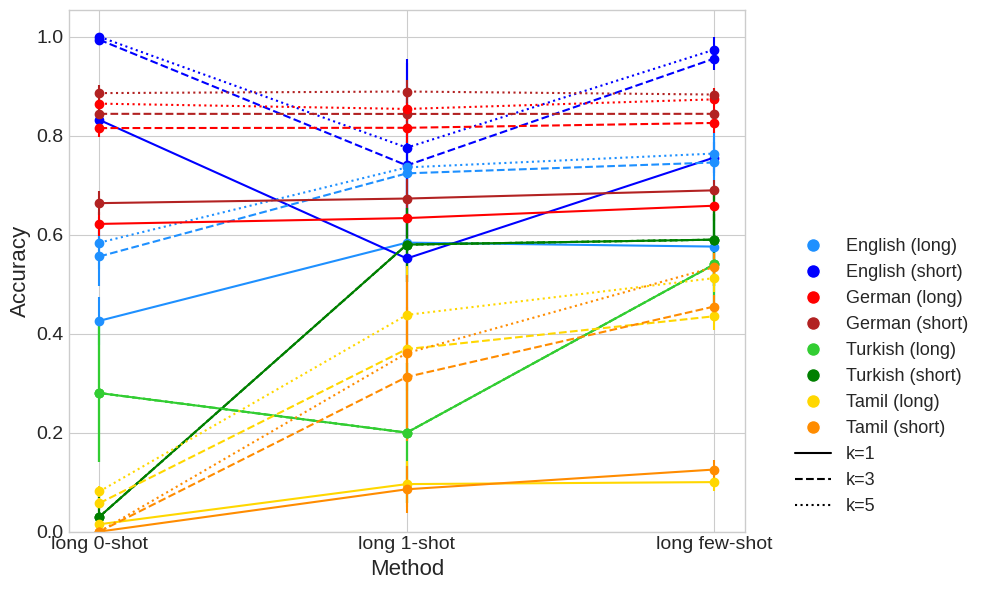

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np

# Create a seaborn-style plot
plt.figure(figsize=(10,6))
plt.style.use('seaborn-whitegrid')

# Split 'Mean ± StdDev' back to float columns 'Mean' and 'StdDev'
df[['Mean', 'StdDev']] = df['Mean ± StdDev'].str.split(' ± ', expand=True)
df['Mean'] = df['Mean'].str.rstrip('%').astype('float') / 100.0
df['StdDev'] = df['StdDev'].str.rstrip('%').astype('float') / 100.0

methods = ['long 0-shot', 'long 1-shot', 'long few-shot']
methods_short = ["short 0-shot", "short 1-shot", "short few-shot"]
k_values = [1, 3, 5]
linestyles = ['-', '--', ':']

# Define color map for the languages
color_mapping = {
    "English": ("dodgerblue", "blue"),
    "German": ("red", "firebrick"),
    "Turkish": ("limegreen", "green"),
    "Tamil": ("gold", "darkorange")
}

x = np.arange(len(methods))  # X-coordinates for the methods

# For each language, plot a line with error bars for each k value
for language, colors in color_mapping.items():
    for j, k in enumerate(k_values):
        for i, methods_group in enumerate([methods, methods_short]):
            df_plot = df[(df['Method'].isin(methods_group)) & (df['K'] == k) & (df['Language'] == language)]
            df_plot = df_plot.fillna(0)
            y = df_plot['Mean']
            error = df_plot['StdDev']
            plt.errorbar(x, y, yerr=error, fmt=linestyles[j]+'o', color=colors[i])

# Define custom legend
colors_legend = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color_pair in color_mapping.values() for color in color_pair]
labels_legend = [f"{language} (long)" if i%2==0 else f"{language} (short)" for language in color_mapping.keys() for i in range(2)]

k_values_legend = [Line2D([0], [0], color='black', linestyle=linestyles[i]) for i in range(len(k_values))]

plt.legend(colors_legend + k_values_legend, labels_legend + [f'k={k}' for k in k_values], loc='lower left', fontsize=13, bbox_to_anchor=(1.05, 0))

# Increase the font size of the tick labels and the axis labels
plt.xticks(x, methods, fontsize=14)  # Set x-ticks to be the method names
plt.yticks(fontsize=14)
plt.xlabel('Method', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)

plt.ylim(bottom=0)  # adjust this as necessary

# Make sure that the margins of the PDF are as small as possible
plt.tight_layout()
plt.savefig('prompting.pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()



# Generating Table 6

In [ ]:
final_results = {}

for method, results in methods_results.items():
    for k in k_values:
        if method == "MinGen":

            accuracies, accuracy_stats = calculate_accuracy_at_k_ipa(results, gold_freq_dict, k, False)
        elif method == "AED":
            accuracies, accuracy_stats = calculate_accuracy_at_k_aed(results, gold_freq_dict, k, False)
        else:
            accuracies, accuracy_stats = calculate_accuracy_at_k(results, gold_freq_dict, k, False)

        if method not in final_results:
            final_results[method] = {}
        final_results[method][k] = accuracy_stats
df_list = []
for method, method_results in final_results.items():
    if method[-4:] == "shot":
        lang_results = method_results[1]["Turkish"]
        df_list.append([method, lang_results['mean'], lang_results['std_dev']])
df = pd.DataFrame(df_list, columns=['Method', 'Mean', 'StdDev'])

# Combine 'Mean' and 'StdDev' into 'Mean ± StdDev' format, suppress '±' for 0 std dev
df['Mean ± StdDev'] = df.apply(lambda row: f"{row['Mean']*100:.2f} ± {row['StdDev']*100:.2f}" if row['Mean'] != '' and row['StdDev'] != 0 else f"{row['Mean']*100:.2f}", axis=1)

# Drop the original 'Mean' and 'StdDev' columns
df.drop(columns=['Mean', 'StdDev'], inplace=True)

# Add two new columns to represent the separate dimensions
df['Type'] = df['Method'].apply(lambda x: 'short' if 'short' in x else 'long')
df['Shot'] = df['Method'].apply(lambda x:x.split(' ')[1])


# Drop the 'Method' column as it's no longer needed
df.drop(columns=['Method'], inplace=True)

# Pivot the DataFrame to get 'Type' as the index and 'Shot' as the columns
df_pivot = df.pivot(index='Type', columns='Shot', values='Mean ± StdDev')

# Convert the pivot table to LaTeX
latex_table = df_pivot.to_latex(index=True, escape=False, column_format='ll')

# If you want to include booktabs package
latex_table = re.sub(r'\\toprule', '\\\\toprule', latex_table)
latex_table = re.sub(r'\\midrule', '\\\\midrule', latex_table)
latex_table = re.sub(r'\\bottomrule', '\\\\bottomrule', latex_table)

print(latex_table)



\begin{tabular}{ll}
\toprule
Shot &       0-shot &        1-shot &      few-shot \\
Type  &              &               &               \\
\midrule
long  &  3.00 ± 1.80 &  20.67 ± 5.73 &  33.33 ± 4.94 \\
short &  7.00 ± 4.33 &  18.67 ± 6.18 &  31.00 ± 4.23 \\
\bottomrule
\end{tabular}



<ipython-input-14-63e7865f027a>:41: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = df_pivot.to_latex(index=True, escape=False, column_format='ll')


# Generating Figures 3-7

Unknown

Method: long 0-shot
  Language: German


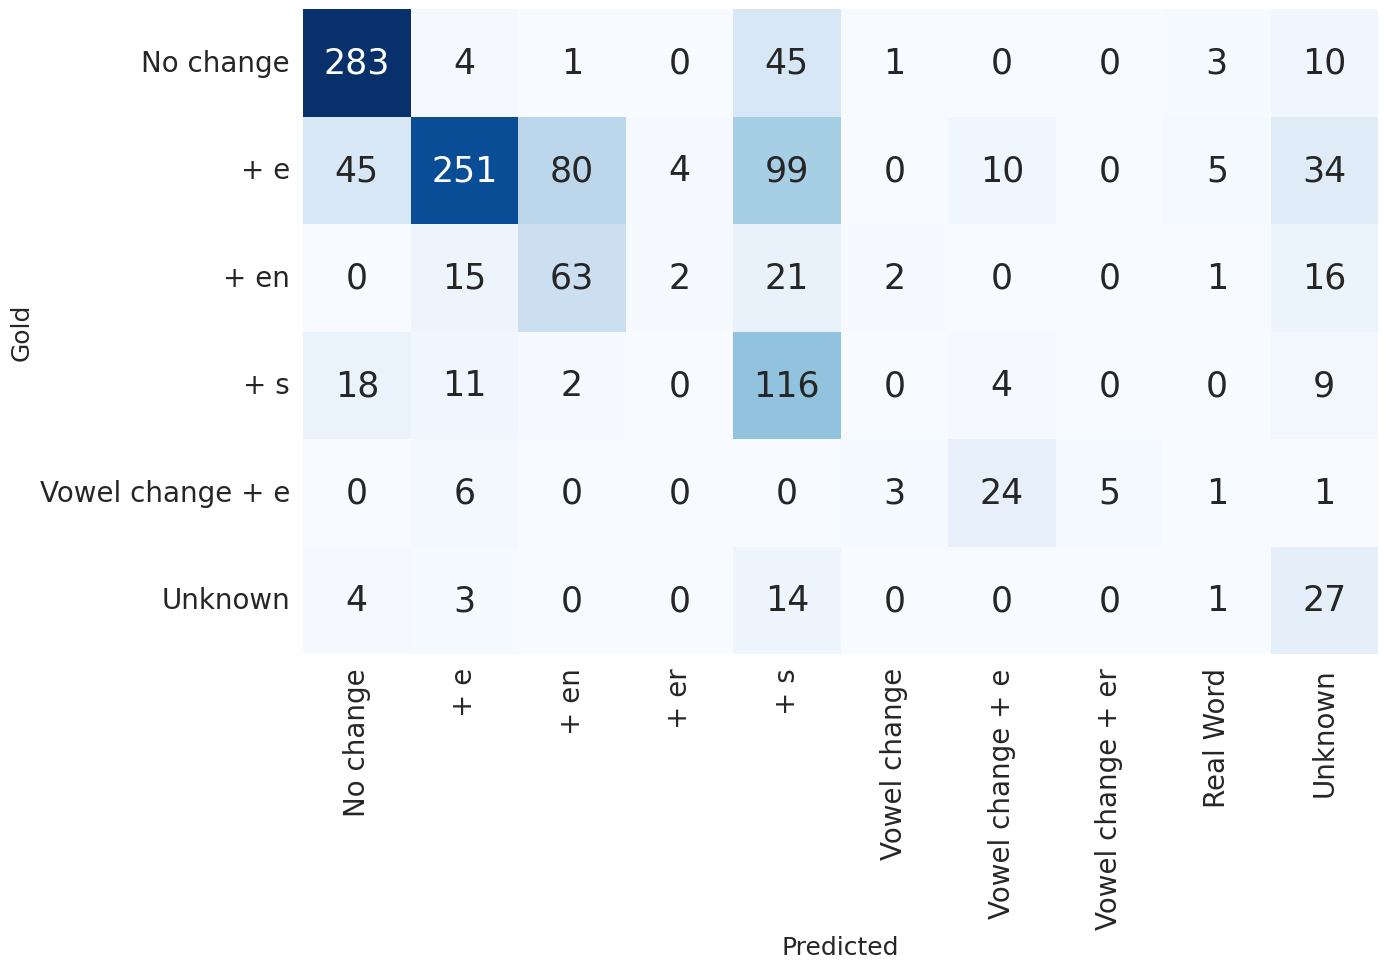

  Language: English


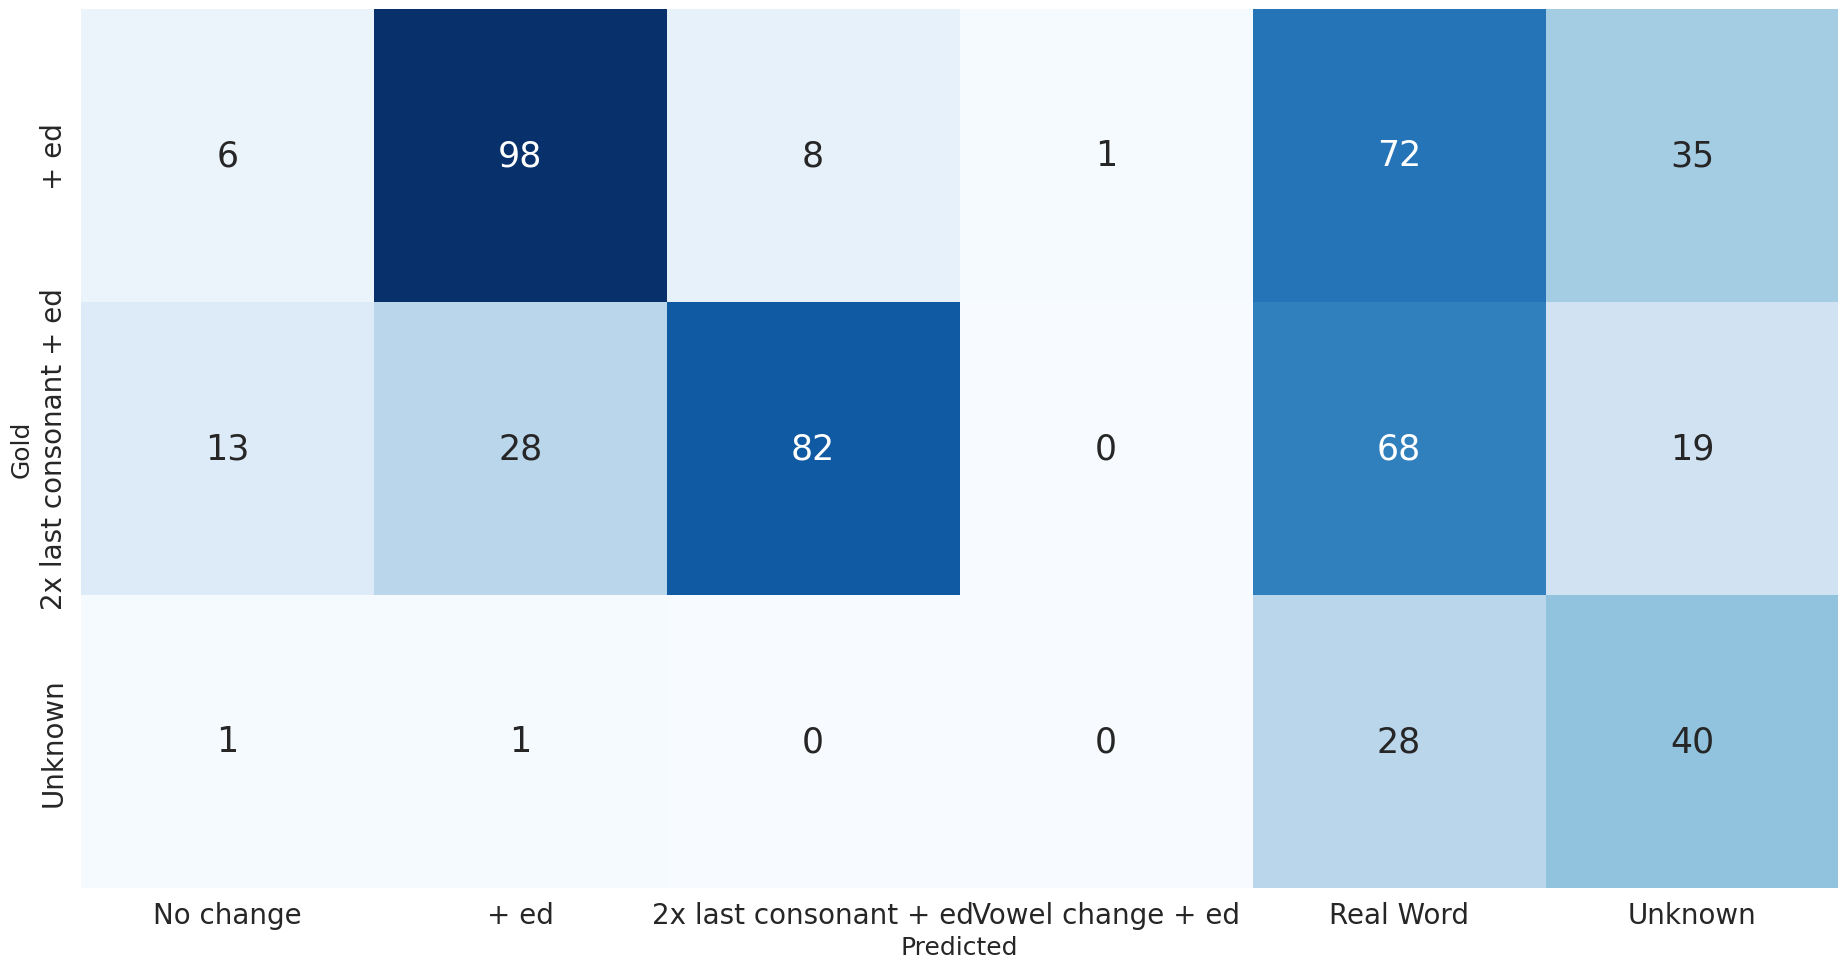


Method: long 1-shot
  Language: German


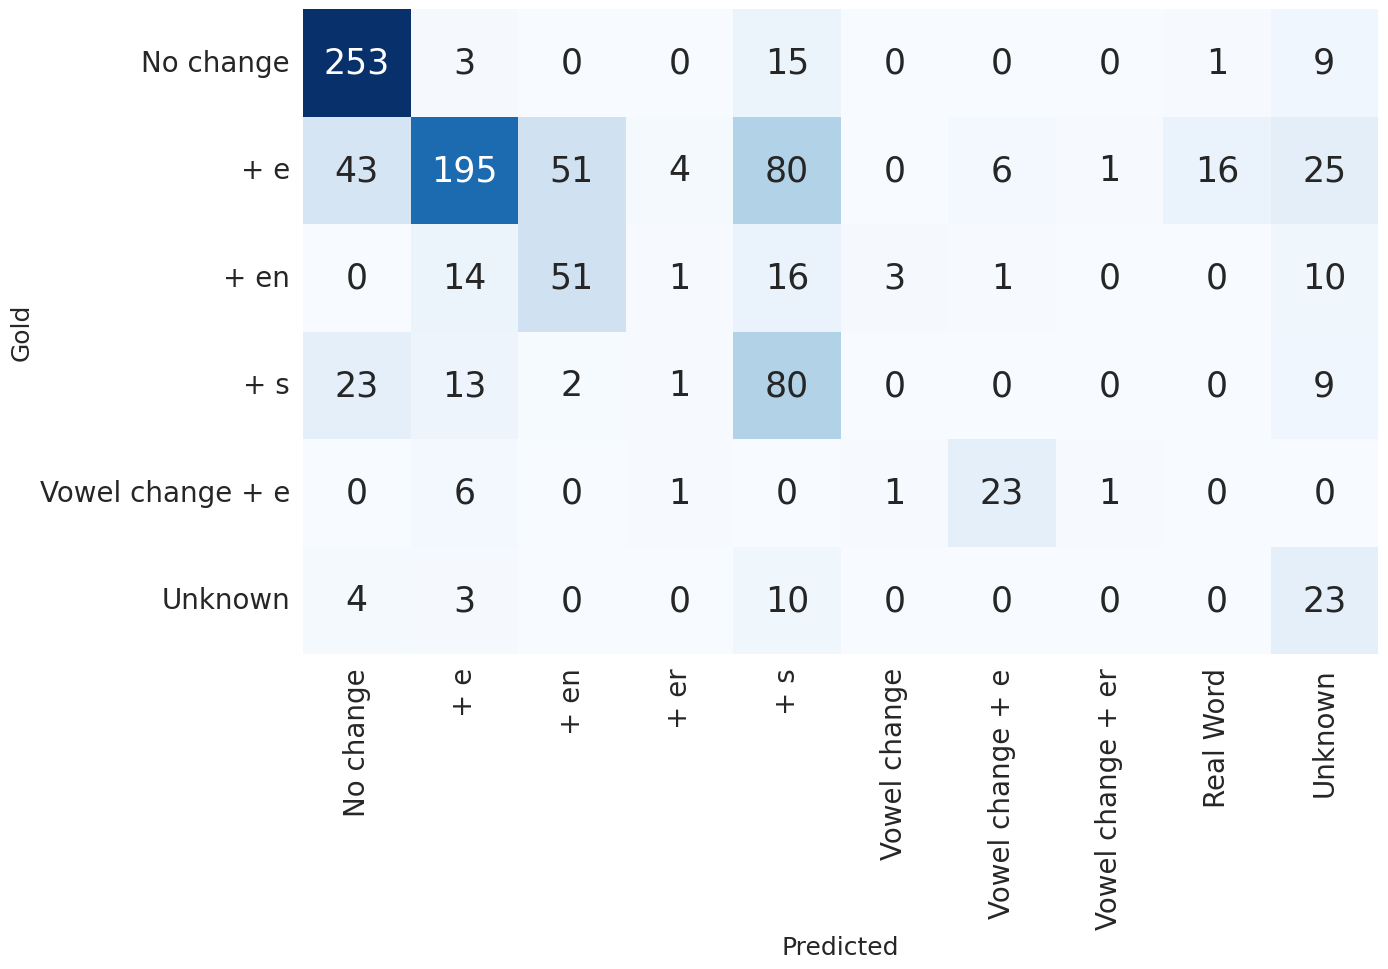

  Language: English


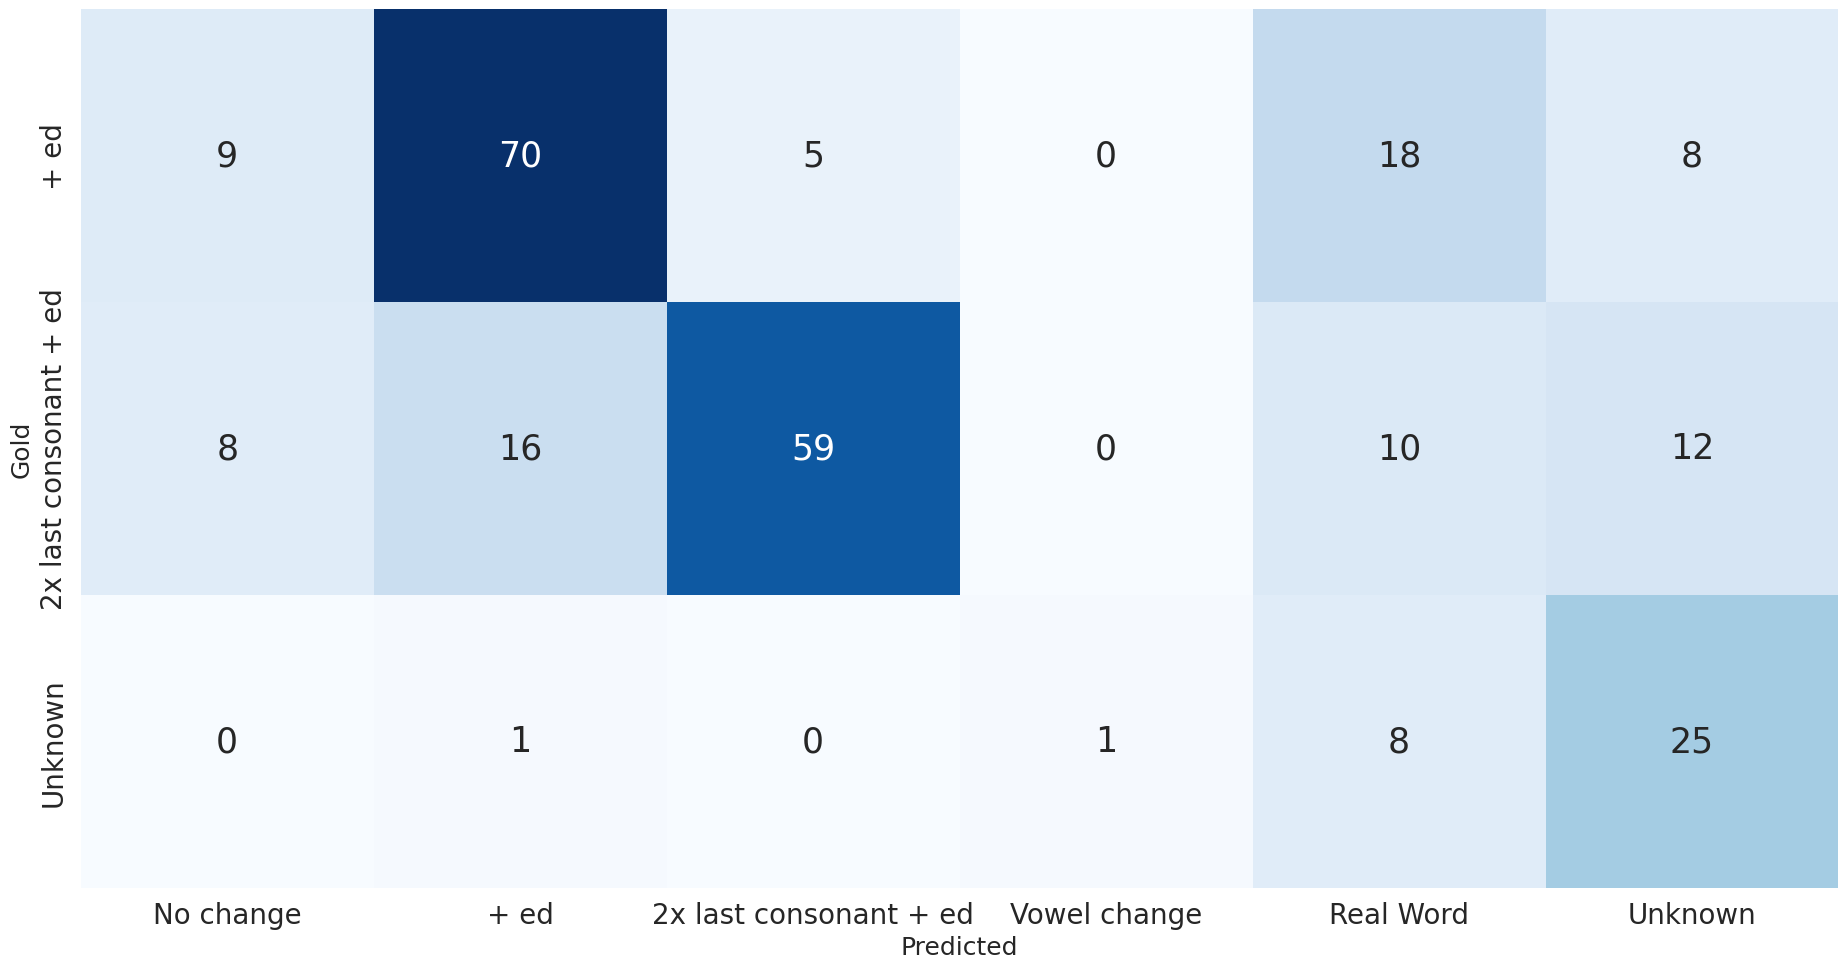


Method: long few-shot
  Language: German


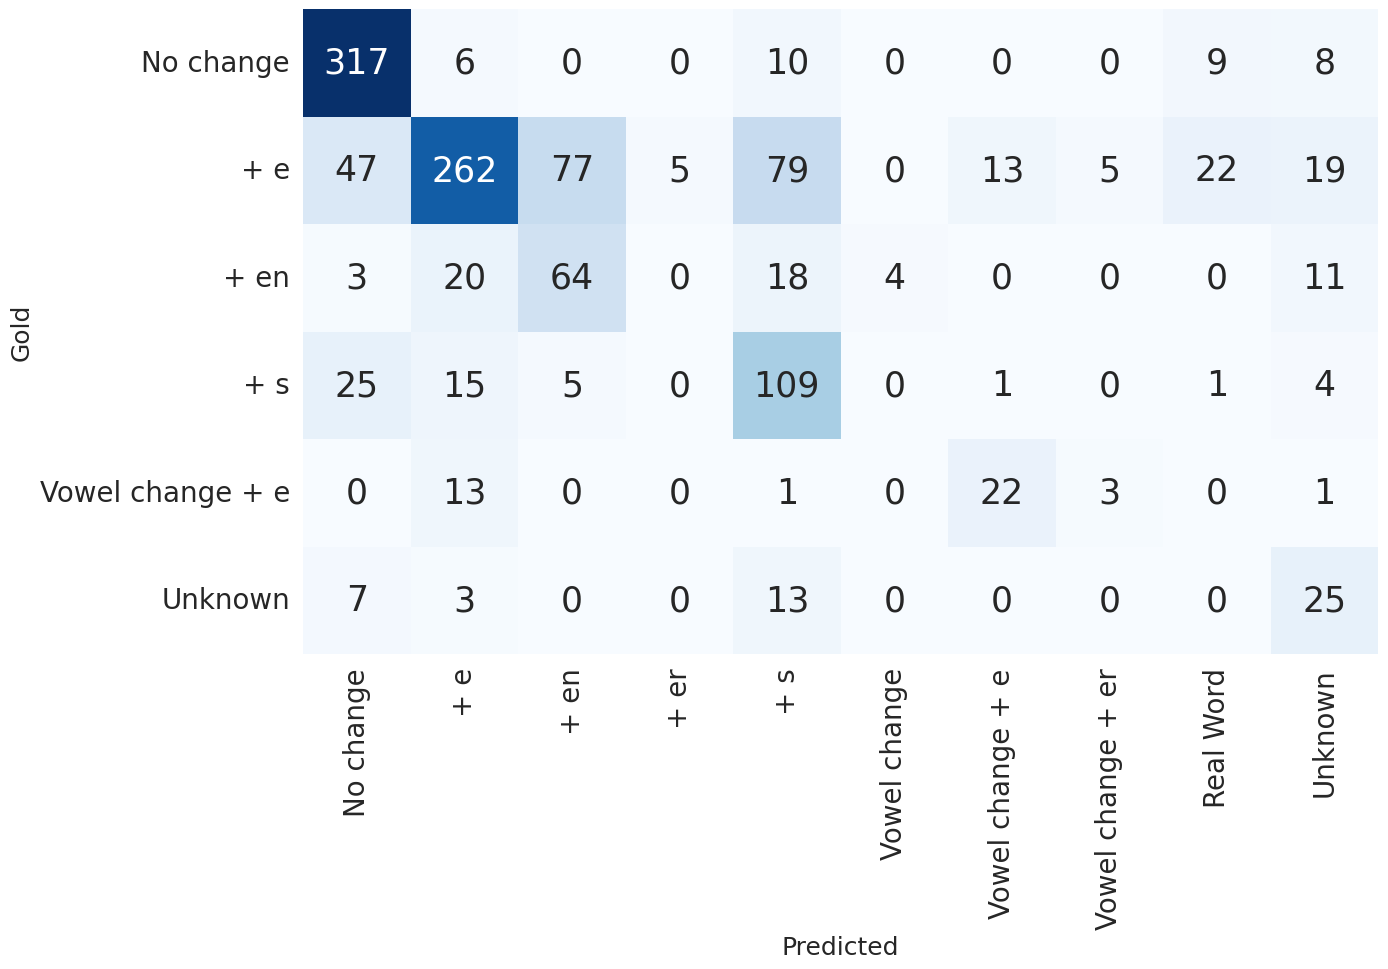

  Language: English


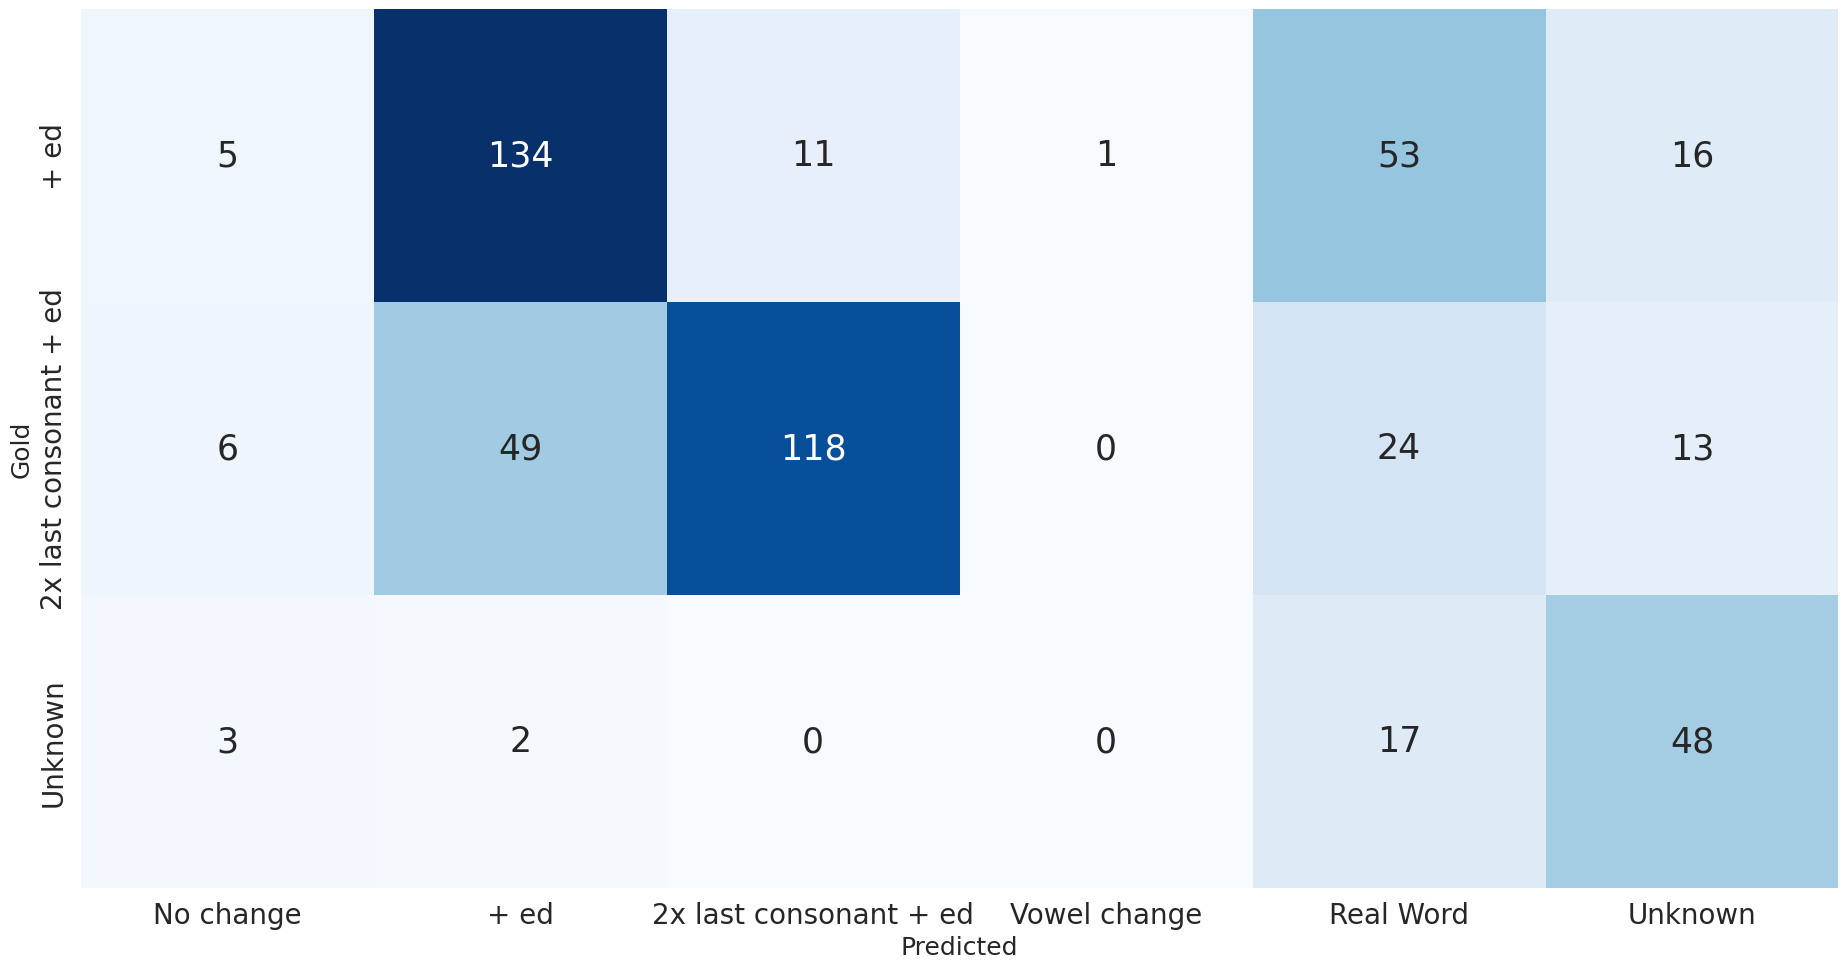


Method: short 0-shot
  Language: German


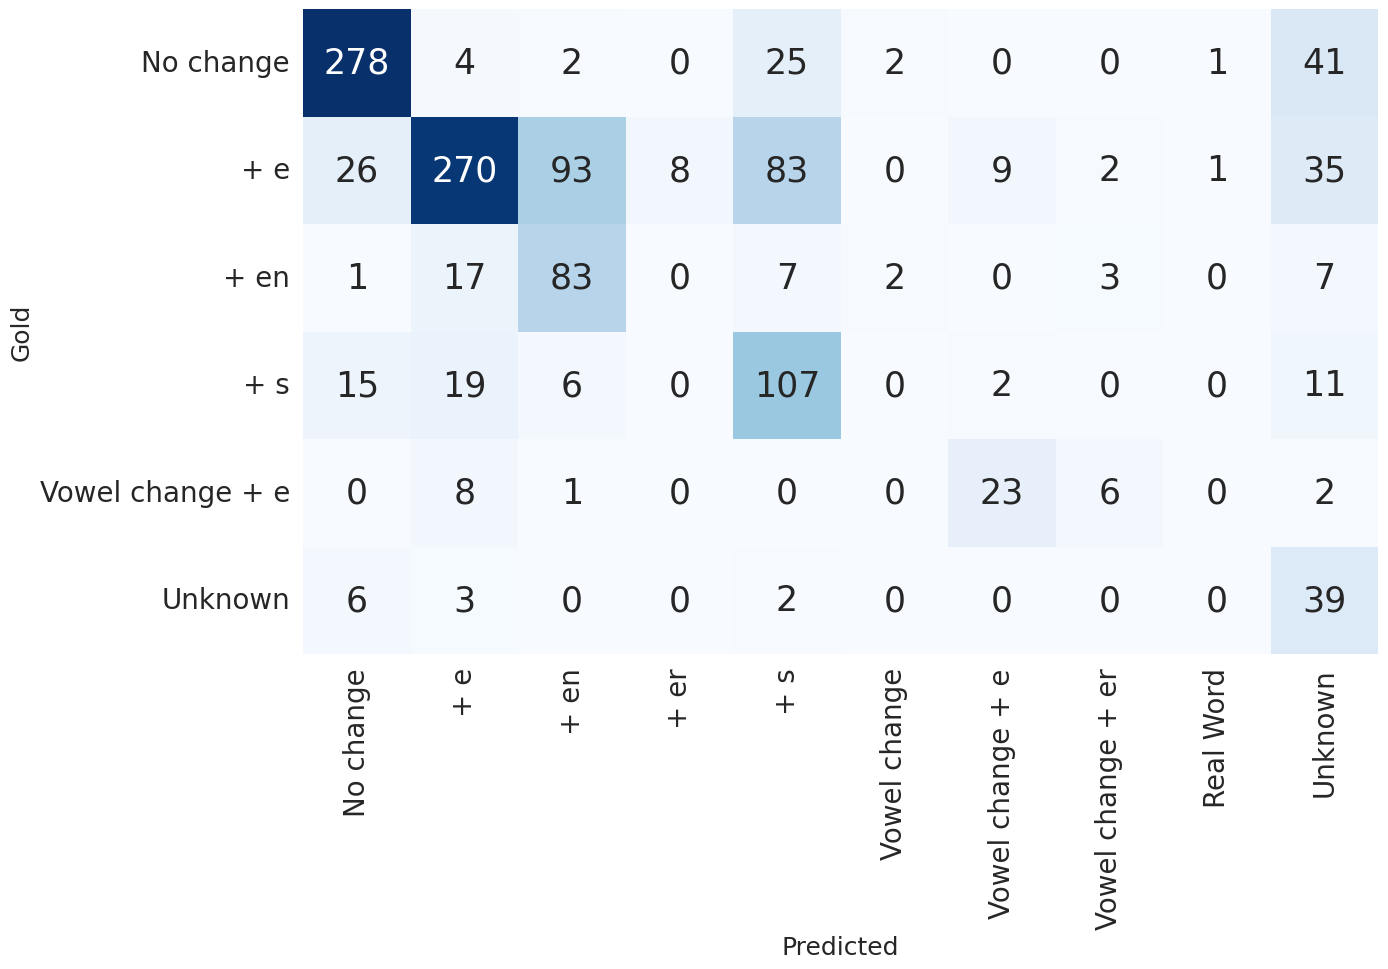

  Language: English


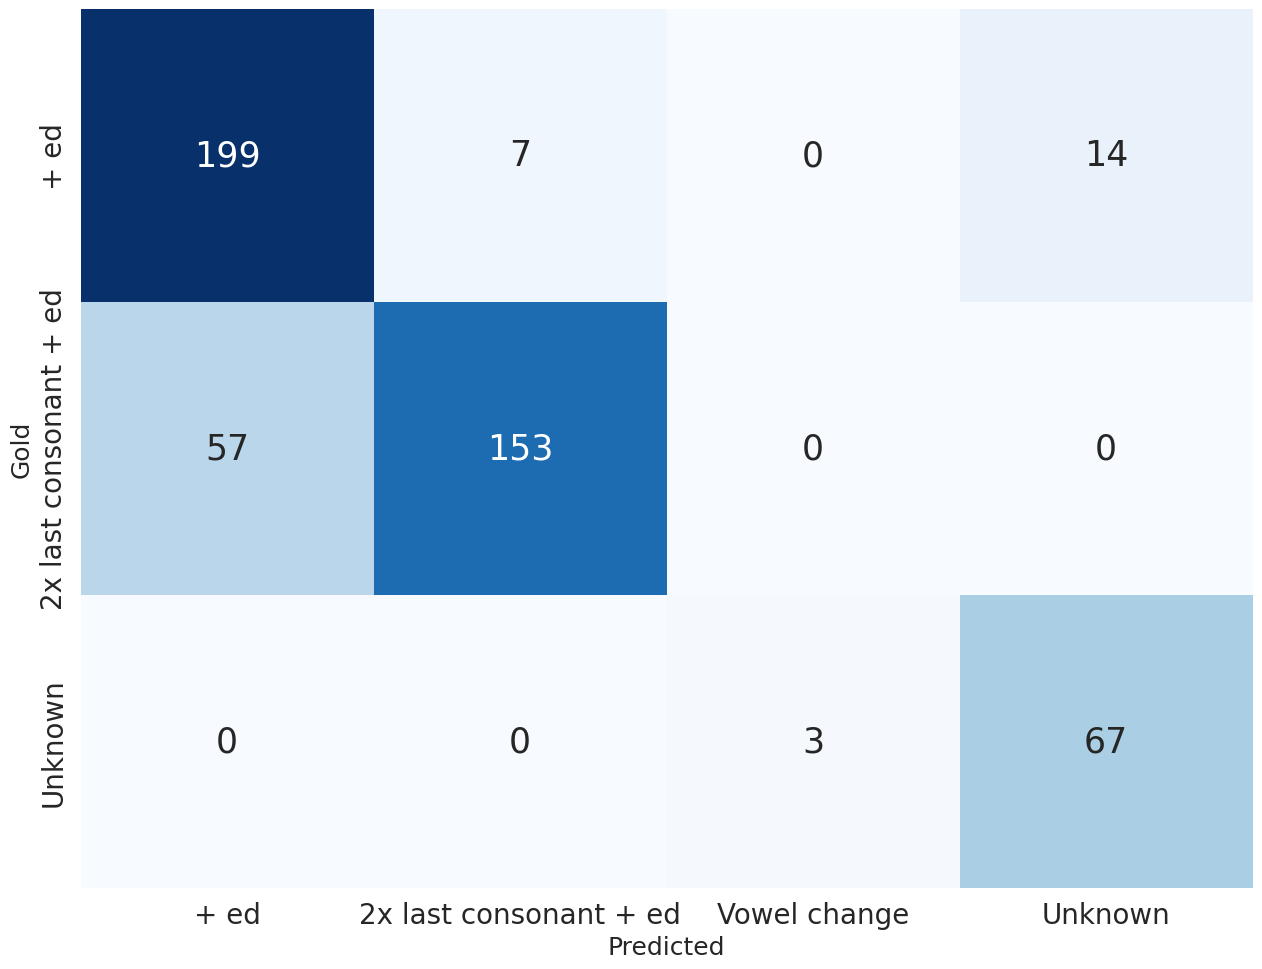


Method: short 1-shot
  Language: German


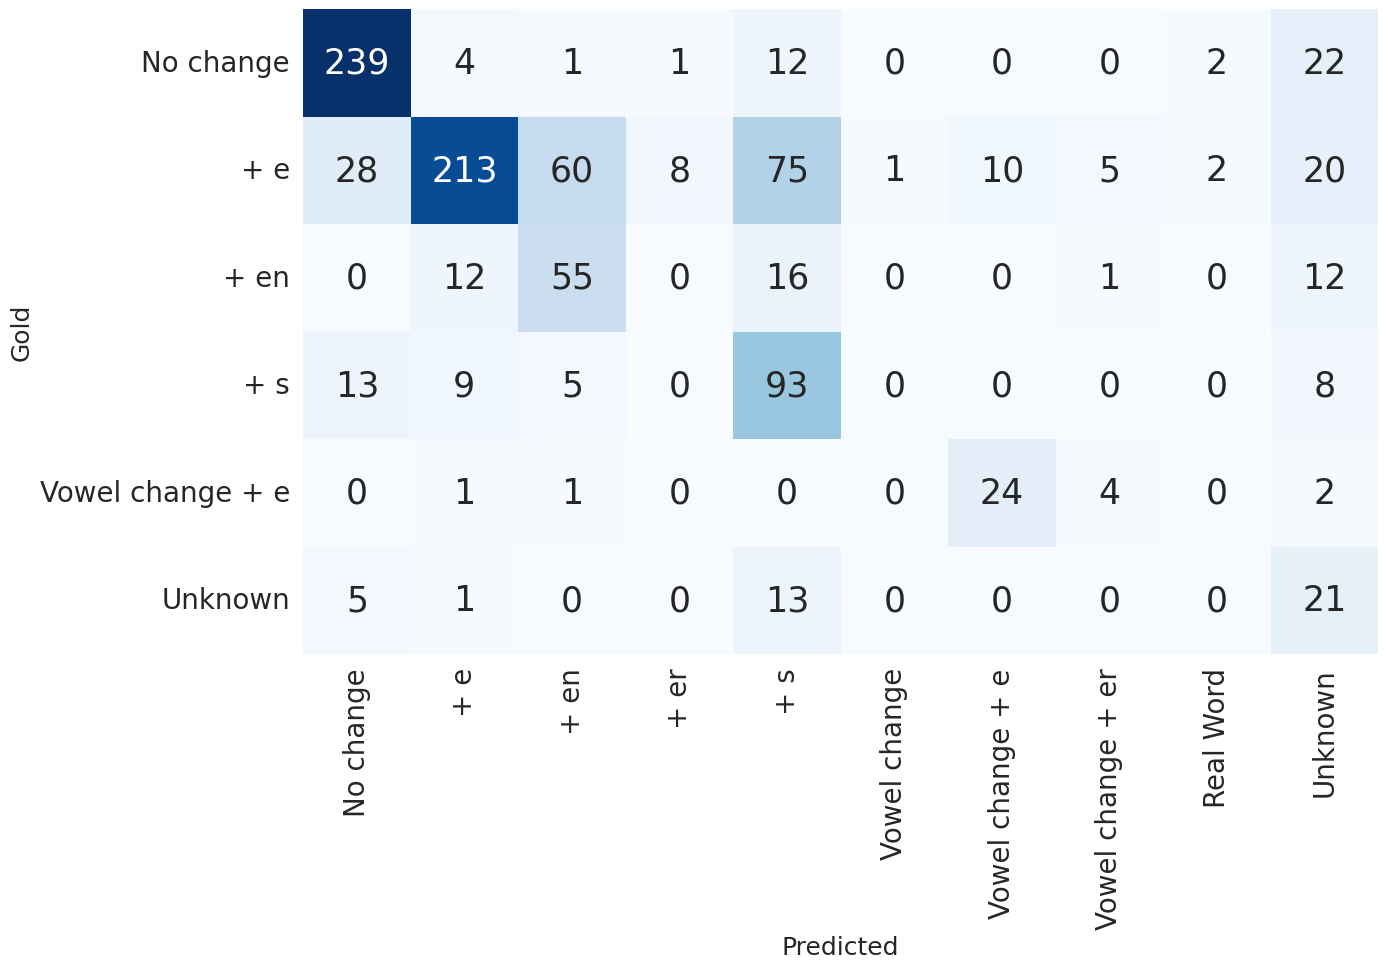

  Language: English


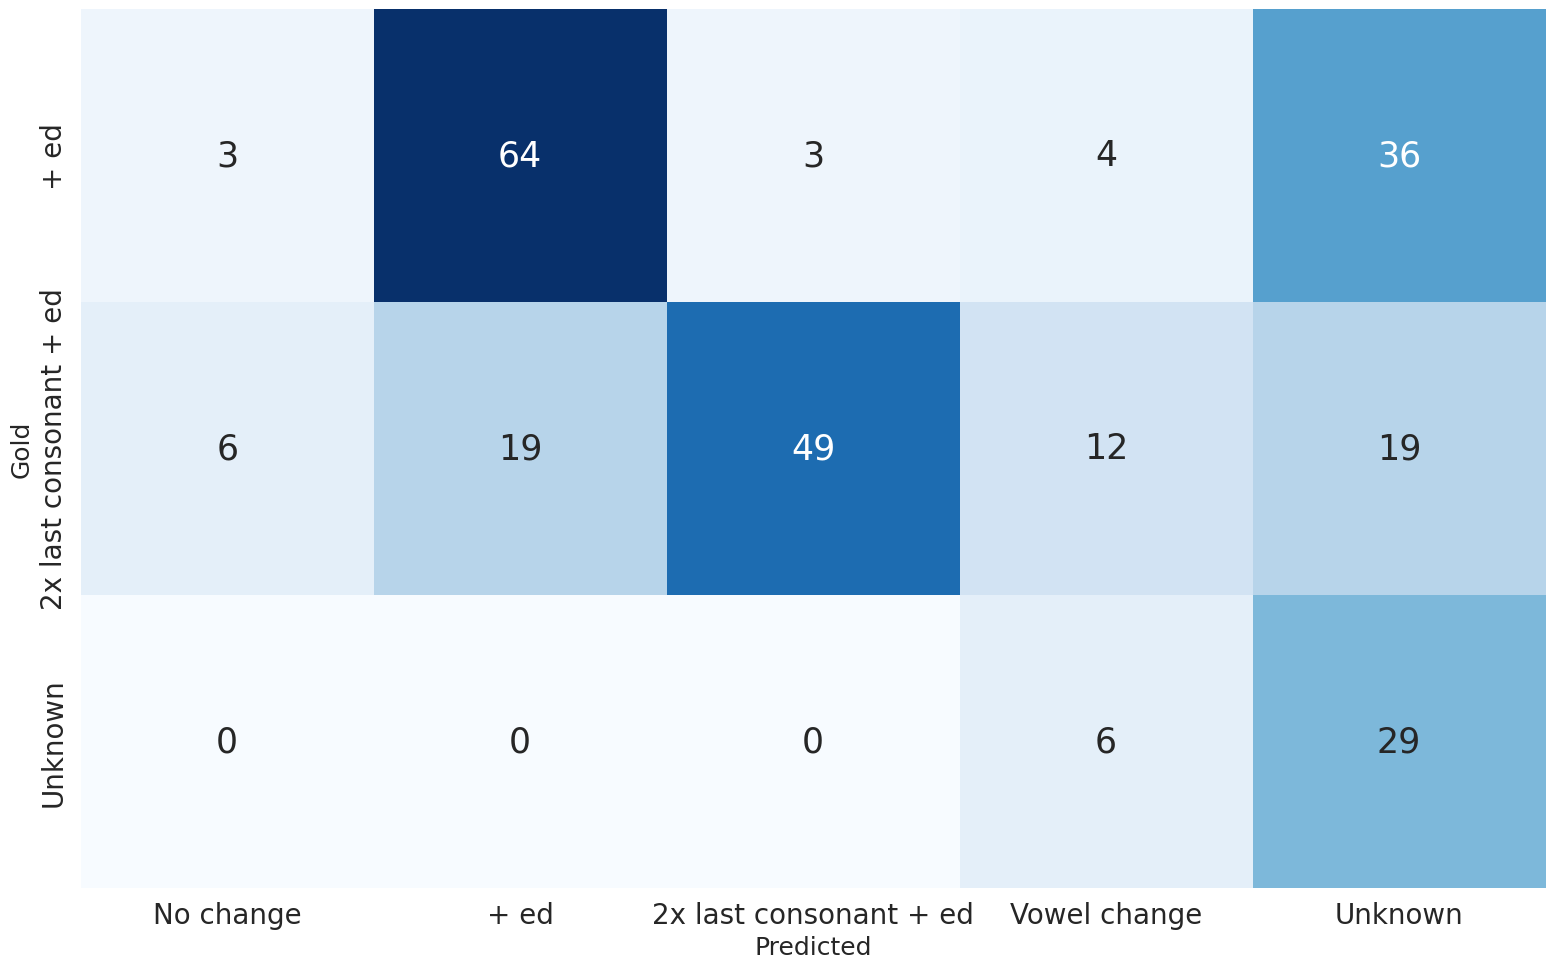


Method: short few-shot
  Language: German


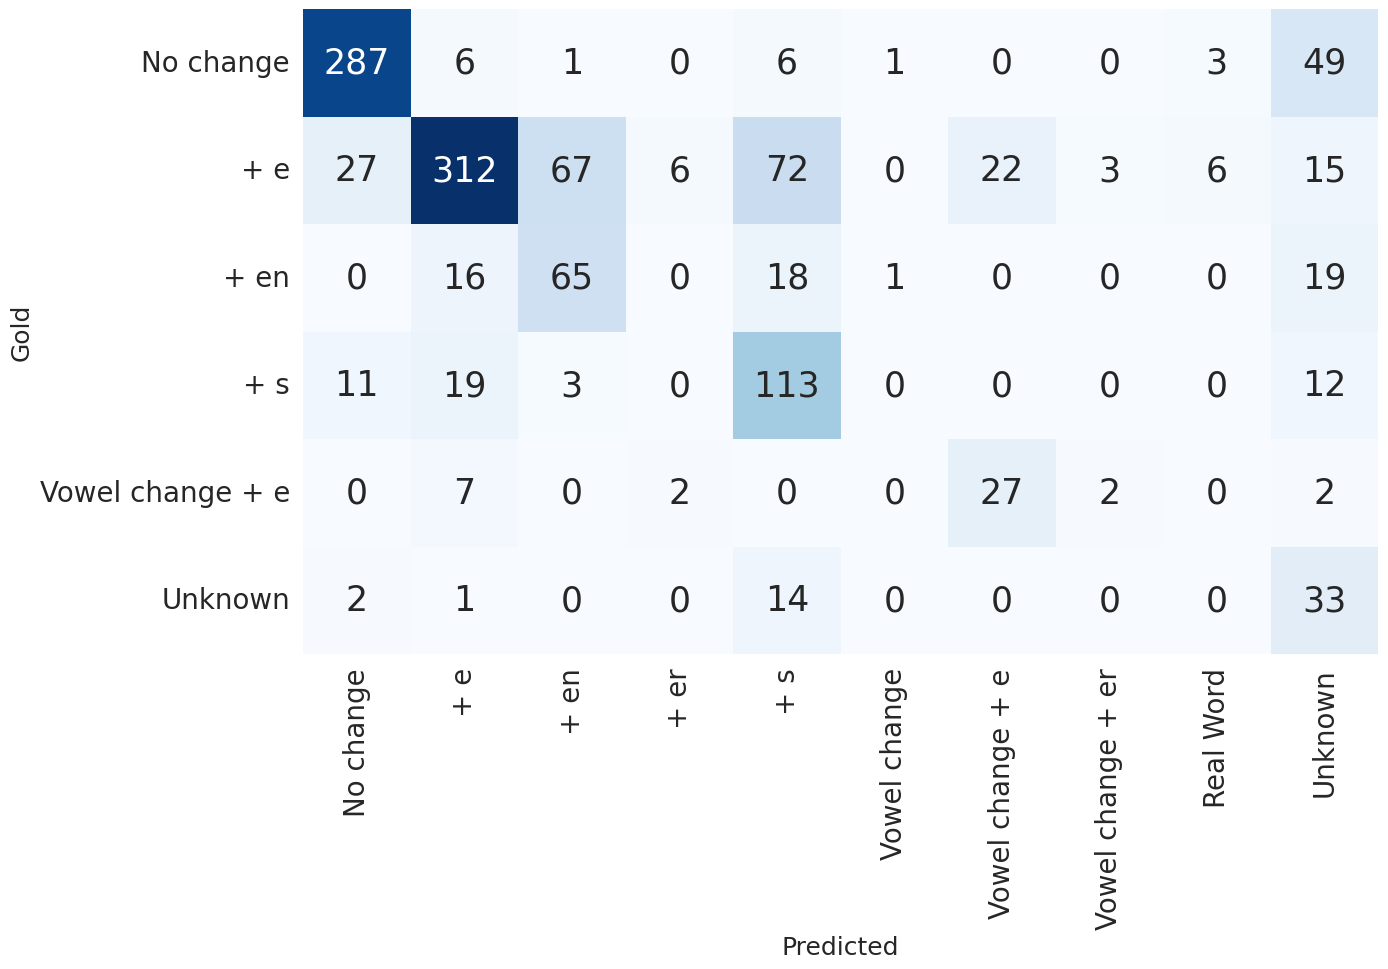

  Language: English


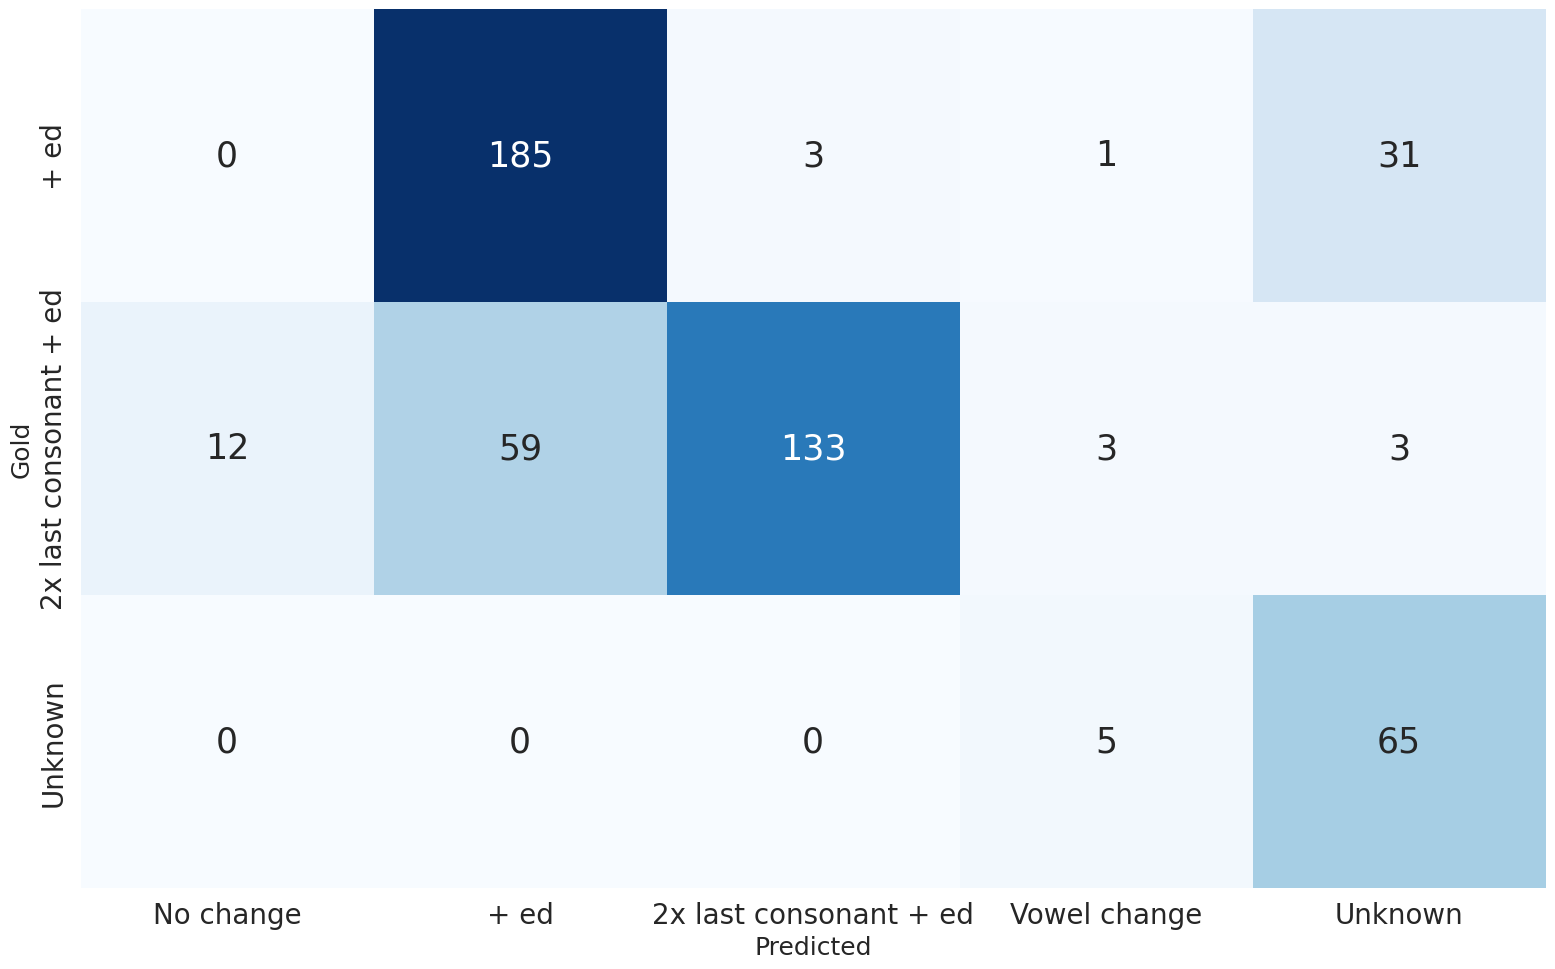

In [ ]:
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

real_words={}
real_words["English"] = ['ate', 'bet', 'blundered', 'blushed', 'bowled', 'cast', 'changed', 'chugged', 'did', 'died', 'dragged', 'drained', 'drank', 'drew', 'drove', 'felt', 'form', 'fried', 'further', 'had', 'hazarded', 'hazed', 'imbued', 'jangled', 'lasted', 'lied', 'listened', 'made', 'met', 'owed', 'quivered', 'read', 'rope', 'roused', 'sang', 'saw', 'scanned', 'scene', 'scented', 'shot','snaked','stuttered','taught', 'tense', 'trained','tried', 'trimmed','trusted', 'used', 'veered', 'verb', 'viewed','went', 'wept','word']
real_words["German"] = ["Ampeln", "Bestien", "Brüder", "Dritte", "Gefäße", "Hasen", "Hier", "Institute", "Kapitale", "Keine", "Kolonien", "Kommunen", "Küken", "Masken", "Meister", "Möhren", "Ozeane", "Ozeanen", "Präsente", "Rabatte", "Reichen", "Römer", "Schreiber", "Seiden", "Sklaven", "Studenten", "Update", "Ärscher"]


def classify_tuple(word_tuple, lang):
    vowels = "aeiou"

    word, plural = word_tuple

    if lang == "German":
        suffixes = {"e": "+ e", "en": "+ en", "er": "+ er", "s": "+ s", "n": "+ n"}
        transformations = {"a": "ä", "o": "ö", "u": "ü"}
    elif lang == "English":
        suffixes = {"ed": "+ ed", "ted": "2x last consonant + ed"}
    if word == plural:
        return "No change"
    elif plural in real_words[lang]:
        if word not in ["test", "teach", "build", "sing", "hit"]:
            return "Real Word"
    else:
        for suffix, rule in suffixes.items():
            if word + suffix == plural:
                return rule
            elif word[-1] not in vowels and word + word[-1] + suffix == plural:
                return "2x last consonant + ed"
        else:
            if lang == "English":
                for v1 in vowels:
                    for v2 in vowels:
                        if v1 != v2:
                            transformed_word, num_subs = re.subn(v1, v2, word)
                            if num_subs > 0:
                                if transformed_word == plural:
                                    return "Vowel change"
                                elif transformed_word + "ed" == plural:
                                    return "Vowel change + ed"
            elif lang == "German":
                for vowel, transformed_vowel in transformations.items():
                    transformed_word, num_subs = re.subn(vowel, transformed_vowel, word)
                    if num_subs > 0:
                        if transformed_word == plural:
                            return "Vowel change"
                        elif transformed_word + "e" == plural:
                            return "Vowel change + e"
                        elif transformed_word + "er" == plural:
                            return "Vowel change + er"
    return "Unknown"


# Using the function for a single word
print(classify_tuple(("sing", "sang"), "English"))
k = 1
confusion_matrix_labels = {}
confusion_matrix_labels["English"] = ["No change", "+ ed", "2x last consonant + ed", "Vowel change", "Vowel change + ed", "Real Word", "Unknown"]
confusion_matrix_labels["German"] = ["No change", "+n", "+ e", "+ en", "+ er", "+ s", "Vowel change", "Vowel change + e", "Vowel change + er", "Real Word", "Unknown"]
# Confusion matrix
for method_name, results in methods_results.items():
    if method_name[-4:] != "shot":continue
    print(f"\nMethod: {method_name}")

    for lang, lang_results in results.items():
        if lang not in ["German", "English"]: continue
        print(f"  Language: {lang}")
        wug_lang_list = wug_list[lang]
        gold_classes = []
        result_classes = []
        for row_i, result_items in lang_results.iterrows():
            for idx, (result, column_freq_dict) in enumerate(zip(result_items, gold_freq_dict[lang])):
                best_gold_key = max(column_freq_dict, key=column_freq_dict.get)
                wug_word = wug_lang_list[idx]
                gold_pair = (wug_word, best_gold_key)
                result_pair = (wug_word, result)
                gold_class = classify_tuple(gold_pair, lang)
                result_class = classify_tuple(result_pair, lang)
                gold_classes.append(gold_class)
                result_classes.append(result_class)

        # Confusion matrix
        conf_matrix = confusion_matrix(gold_classes, result_classes, labels=confusion_matrix_labels[lang])
        conf_matrix_df = pd.DataFrame(conf_matrix, columns=confusion_matrix_labels[lang], index = confusion_matrix_labels[lang])

        # Remove zero rows and columns
        conf_matrix_df = conf_matrix_df.loc[:, (conf_matrix_df != 0).any(axis=0)]
        conf_matrix_df = conf_matrix_df.loc[(conf_matrix_df != 0).any(axis=1), :]
        conf_matrix_df.index.name = 'Gold'
        conf_matrix_df.columns.name = 'Predicted'

        # Adjust aspect according to the shape of dataframe
        aspect_ratio = conf_matrix_df.shape[1] / conf_matrix_df.shape[0]

        plt.figure(figsize = (10 * aspect_ratio, 10)) # Here, we adjust the width of the figure according to aspect ratio
        # plt.title(f'Confusion Matrix for {lang}, {method_name} prompting', fontsize=20)  # add a title and increase fontsize
        sns.set(font_scale=1.4)  # set the font scale for seaborn
        hm = sns.heatmap(conf_matrix_df, cmap="Blues", annot=True, annot_kws={"size": 25}, fmt='g', square=True, cbar=False)
        hm.set_xticklabels(hm.get_xticklabels(), fontsize = 20)  # increase x-axis tick label fontsize
        hm.set_yticklabels(hm.get_yticklabels(), fontsize = 20)  # increase y-axis tick label fontsize
        plt.xlabel('Predicted', fontsize=18)  # increase x-axis label fontsize
        plt.ylabel('Gold', fontsize=18)  # increase y-axis label fontsize
        plt.tight_layout()
        plt.savefig(f'{lang}_{method_name}.pdf', bbox_inches='tight', pad_inches=0.1)  # 'g' format for general number formatting
        plt.show()



# Compute Statistically Significant Correlations with one-shots

In [ ]:
from scipy.stats import spearmanr
from collections import Counter
import numpy as np
from scipy.stats import pearsonr
from scipy.stats import chi2_contingency

# Create an empty dictionary to store the classification frequency for each language
classification_frequency = {"English": {}, "German": {}}

for method_name, results in methods_results.items():
    if method_name != "1-shot":
        continue

    for lang, results_list in results.items():
        print(lang)
        if lang not in ["German", "English"]:
            continue

        # Get the one-shot list and the wug list for the current language
        one_shot_list = one_shot_lists[lang]
        wug_lang_list = wug_list[lang]

        # Lists to store the classes of the one-shots and the results
        one_shot_classes = []
        class_freqs = []

        for one_shot, (_, result_column) in zip(one_shot_list, results_list.iterrows()):
            result_classes = []
            # Get the one-shot pair
            one_shot_pair = tuple(one_shot.split('-'))

            # Classify the one-shot pair
            one_shot_class = classify_tuple(one_shot_pair, lang)

            # Store the one-shot class
            one_shot_classes.append(one_shot_class)

            # Count the frequency of the one-shot class
            if one_shot_class in classification_frequency[lang]:
                classification_frequency[lang][one_shot_class] += 1
            else:
                classification_frequency[lang][one_shot_class] = 1

            result_items = list(result_column)

            for idx, result in enumerate(result_items):
                # Get the result pair
                wug_word = wug_lang_list[idx]
                result_pair = (wug_word, result)

                # Classify the result pair
                result_class = classify_tuple(result_pair, lang)

                # Store the result class
                result_classes.append(result_class)

            result_class_freqs = Counter(result_classes)
            class_freqs.append(result_class_freqs)

        for i, one_shot in enumerate(one_shot_list):
            # get the frequency of the one-shot within its own associated dictionary

            one_shot_pair = tuple(one_shot.split('-'))

            # Classify the one-shot pair
            one_shot_class = classify_tuple(one_shot_pair, lang)
            one_shot_freq = class_freqs[i].get(one_shot_class, 0)

            # get the total frequency of all other items within the same dictionary
            total_freq_same = sum(v for k, v in class_freqs[i].items() if k != one_shot_class)

            # get the frequency of the one-shot within all other dictionaries
            one_shot_freq_others = sum(d.get(one_shot_class, 0) for j, d in enumerate(class_freqs) if j != i)

            # get the total frequency of all other items within all other dictionaries
            total_freq_others = sum(sum(v for k, v in d.items() if k != one_shot_class) for j, d in enumerate(class_freqs) if j != i)

            # construct the contingency table
            table = [[one_shot_freq, one_shot_freq_others], [total_freq_same, total_freq_others]]

            # perform the chi-square test
            chi2, p, dof, expected = chi2_contingency(table)

            if p < 0.05:

                print(f"Class: {one_shot_class}, Chi2: {chi2}, P-value: {p}")

            else:
                print(f"\t\tClass: {one_shot_class}, Chi2: {chi2}, P-value: {p}")
